# Comparison of Theano compiled and pure Numpy models

In [1]:
from init import *
%matplotlib inline

[monochrome_palette]: value was greater than 1 and was clipped.



import os
import builtins
from collections import OrderedDict, namedtuple, deque
import logging
from multiprocessing import Pool
from zipfile import BadZipFile  # For detecting corrupt files
import numpy as np
from functools import lru_cache, partial
from scipy.special import lambertw
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import theano
from tqdm import tqdm_notebook as tqdm
from parameters import ParameterSet

import theano_shim as shim
import mackelab as ml
import mackelab.iotools
import sinn
from sinn.histories import Series
import sinn.analyze as anlz
import sinn.models

logger = logging.getLogger("linearized_tanh")

plt.style.use('publish')
#plt.style.use('dark_background')
#plt.style.use('default')
plt.rcParams['figure.facecolor'] = (1,1,1,1)
# Use pgf when exporting pdf
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)



In [3]:
from models import TanhModel, LinearModel

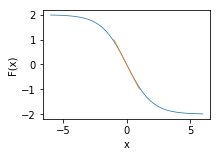

In [4]:
α = -1.; β = 1.;
plt.figure(figsize=(3,2));
xarr = np.linspace(-6*β, 6*β); yarr = TanhModel.F(xarr, α, β); plt.plot(xarr, yarr);
xarr = np.linspace(-β, β); yarr = LinearModel.F(xarr, α, β); plt.plot(xarr, yarr);
plt.xlabel('x'); plt.ylabel('F(x)');
del α, β

In [6]:
ModelParams = namedtuple('ModelParams', ['q', 'Δ', 'α', 'β'])
params = ModelParams(α=-1, β=1, Δ=1, q=1)

## Numpy function

In [6]:
shim.load(load_theano=False)

In [7]:
rndstream = shim.cf.RandomStreams(0)

In [8]:
npmodel = TanhModel(params, 'x_np', random_stream=rndstream)

In [9]:
npmodel.x.pad(npmodel.params.Δ.get_value())
npmodel.x[:npmodel.x.t0idx] = 1

Execution time

In [10]:
%%time
npmodel.advance('end')

CPU times: user 4.46 s, sys: 106 ms, total: 4.56 s
Wall time: 4.26 s


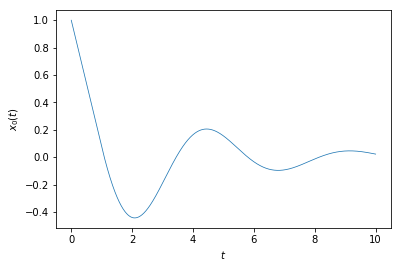

In [11]:
plt.plot(npmodel.x.time, npmodel.x.trace);
plt.xlabel('$t$'); plt.ylabel("$x_0(t)$");

## Compiled function

In [12]:
theano.config.compute_test_value = 'raise'

In [13]:
shim.load(load_theano=True)

In [14]:
rndstream = shim.cf.RandomStreams(0)

In [15]:
tmodel = TanhModel(params, 'x_theano', random_stream=rndstream)

In [16]:
tmodel.x.pad(tmodel.params.Δ.get_value())
tmodel.x[:tmodel.x.t0idx] = 1

Execution time of first run (involves compilation)

In [17]:
%%time
tmodel.advance('end')
#tmodel.advance(1001)

CPU times: user 1.08 s, sys: 170 ms, total: 1.25 s
Wall time: 7.32 s


Subsequent runs are 10x faster than with NumPy

In [18]:
%%time
tmodel.advance('end')
#tmodel.advance(1001)

CPU times: user 94 µs, sys: 0 ns, total: 94 µs
Wall time: 98 µs


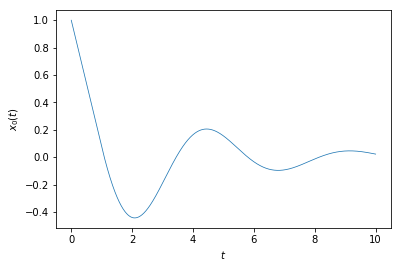

In [19]:
plt.plot(tmodel.x.time, tmodel.x.trace);
plt.xlabel('$t$'); plt.ylabel("$x_0(t)$");